<a href="https://colab.research.google.com/github/MingyuLyu/Railway-Optimal-Control-with-Reinforcement-Learning/blob/main/Stochastic_Environment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
! pip install stable-baselines3[extra]
! pip install gymnasium[all]

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 182.3/182.3 kB 2.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 953.9/953.9 kB 21.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 434.7/434.7 kB 38.0 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Using cached Farama_Notifications-0.0.4-py3-none-any.whl (2.5 kB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 55.7 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.

# Import Helpers


In [2]:
# Import Helpers
from typing import Any

import numpy as np
import random
import os

# Import Gymnasium stuff
import gymnasium as gym
from gymnasium import Env
from gymnasium.core import ObsType
from gymnasium.spaces import Discrete, Box, Dict, Tuple, MultiBinary, MultiDiscrete

# Import Stable Baseline stuff
from stable_baselines3 import TD3, PPO, SAC
from stable_baselines3.common.vec_env import DummyVecEnv
from stable_baselines3.common.evaluation import evaluate_policy
from stable_baselines3.common.env_checker import check_env
from stable_baselines3.common.results_plotter import load_results, ts2xy
from stable_baselines3.common.callbacks import CheckpointCallback
from stable_baselines3.common.evaluation import evaluate_policy
from stable_baselines3.common.env_checker import check_env
from stable_baselines3.common.monitor import Monitor

# Stocahtic Environment  (3 limits)

In [ ]:
class TrainSpeedControl(Env):
    def __init__(self):
        self.dt = 0.1  # in s
        self.sensor_range = 200.0  # in m

        self.position = 0.0  # in m; track is 1-dim, only one coord is needed
        self.velocity = 0.0  # in m/s
        self.acceleration = 0.0  # in m/s**2
        self.jerk = 0.0  # in m/s**3
        self.prev_acceleration = 0.0  # in m/s**2
        self.time = 0.0  # in s
        self.total_energy_kWh = 0.0  # in Wh
        self.reward = 0.0
        # self.speed_limits = 50.0
        # self.final_speed_limits = 0.0001
        self.reward_weights = [1.0, 0.0, 1.0, 1.0]
        self.energy_factor = 1.0
        # print("reward_weights:", self.reward_weights)

        self.track_length = 2500.0
        # second_limit_position = np.random.uniform(500, 1000)
        # self.speed_limit_positions = [0.0, second_limit_position, 1500]
        # self.speed_limits = np.append(np.random.randint(5, 31, size=2), 0)
        self.speed_limit_positions = [0.0, 500.0, 1800.0]
        self.speed_limits = [0.0, 0.0, 0.01]


        self.terminated = False
        self.truncated = False
        self.done = False
        self.episode_count = 0
        self.reroll_frequency = 10

        (self.current_speed_limit, self.future_speed_limits,
         self.future_speed_limit_distances_speed_limit_distance) = self.sensor(self.position)

        self.specs = {
            'mass': 1000,
            'frontal_area': 2.38,
            'cW': 0.29,
            'acceleration_limits': [-1, 1],
            'velocity_limits': [-1, 100],
            'power_limits': [-50, 75],
            'track_length': [0, 1000]
        }

        """
        # Meaning of state features
        # 1. Train's current velocity
        # 2. Train's acceleration of last time step
        # 3. Current speed limit
        # 4. Next speed limit
        # 5. Distance to next speed limit
        """

        # self.state_max = np.hstack(
        #     (self.specs['velocity_limits'][1],
        #      self.specs['acceleration_limits'][1],
        #      self.specs['velocity_limits'][1],
        #      self.specs['velocity_limits'][1],
        #      self.specs['track_length'][1]))

        # self.state_min = np.hstack(
        #     (self.specs['velocity_limits'][0],
        #      self.specs['acceleration_limits'][0],
        #      self.specs['velocity_limits'][0],
        #      self.specs['velocity_limits'][0],
        #      self.specs['track_length'][0],))
        self.state_max = np.hstack(
              (self.specs['velocity_limits'][1],
                self.specs['acceleration_limits'][1],
                self.specs['velocity_limits'][1],
                self.specs['velocity_limits'][1] * np.ones(2),
                self.sensor_range * np.ones(2)))
        self.state_min = np.hstack(
              (self.specs['velocity_limits'][0],
                self.specs['acceleration_limits'][0],
                self.specs['velocity_limits'][0],
                self.specs['velocity_limits'][0] * np.ones(2), np.zeros(2)))

        self.action_space = Box(low=-1.0,
                                high=1.0,
                                shape=(1,),
                                dtype=np.float32)

        self.observation_space = Box(low=self.state_min,
                                     high=self.state_max,
                                     dtype=np.float64)

    def step(self, action):
        """
        Take one 10Hz step:
        Update time, position, velocity, jerk, limits.
        Check if episode is done.
        Get reward.
        :param action: float within (-1, 1)
        :return: state, reward, done, info
        """

        assert self.action_space.contains(action), \
            f'{action} ({type(action)}) invalid shape or bounds'
        self.acceleration = np.clip(action, -1, 1)[0]
        # s = 0.5 * a * t² + v0 * t + s0
        self.position += (0.5 * self.acceleration * self.dt ** 2 +
                          self.velocity * self.dt)
        # v = a * t + v0
        self.velocity += self.acceleration * self.dt
        (self.current_speed_limit, self.future_speed_limits,
         self.future_speed_limit_distances) = self.sensor(self.position)

        self.time += self.dt
        self.jerk = abs((self.acceleration - self.prev_acceleration)) / self.dt
        self.prev_acceleration = self.acceleration
        self.terminated = bool(self.position >= self.track_length or self.time > 210.0)
        if self.terminated:
          self.episode_count += 1
        # self.done = bool(self.time > 500.0)
        # self.truncated = bool(self.position < 0 or self.velocity < 0 or
        #                       self.velocity > self.specs['velocity_limits'][1])
        self.truncated = False

        reward_list = self.get_reward()
        self.reward = np.array(reward_list).dot(np.array(self.reward_weights))
        # print("velocity:", self.velocity)
        # print("reward:", self.reward)

        info = {
            'position': self.position,
            'velocity': self.velocity,
            'acceleration': self.acceleration,
            'jerk': self.jerk,
            'time': self.time,
            'energy': self.total_energy_kWh,
            'reward': self.reward
        }


        # state = self.feature_scaling(self.get_state())
        state = np.hstack([self.velocity, self.prev_acceleration, self.current_speed_limit,
                          self.future_speed_limits, self.future_speed_limit_distances])
        # reward = np.array(reward_list).dot(np.array(self.reward_weights))
        # print("state:", state)
        return state, self.reward, self.terminated, self.truncated, info

    def reset(
            self,
            *,
            seed: int | None = None,
            options: dict[str, Any] | None = None,
    ):
        self.position = 0.0  # in m; track is 1-dim, only one coord is needed
        self.velocity = 0.0  # in m/s
        self.acceleration = 0.0  # in m/s**2
        self.jerk = 0.0  # in m/s**3
        self.prev_acceleration = 0.0  # in m/s**2
        self.time = 0.0  # in s
        self.total_energy_kWh = 0.0  # in Wh
        self.terminated = False
        self.truncated = False
        self.current_speed_limit = 0.0
        self.future_speed_limits = 0.0
        self.future_speed_limit_distances = 0.0


        if self.episode_count % self.reroll_frequency == 0:
            second_limit_position = np.random.uniform(500, 1000)
            self.speed_limit_positions = [0.0, second_limit_position, 1800]
            self.speed_limits = np.append(np.random.randint(5, 21, size=2), 0.0)

        # Update to call sensor method to initialize speed limits correctly
        (self.current_speed_limit, self.future_speed_limits, self.future_speed_limit_distances) = self.sensor(self.position)
        # print("current_speed_limit:", self.current_speed_limit)
        info = {
            'position': self.position,
            'velocity': self.velocity,
            'acceleration': self.acceleration,
            'jerk': self.jerk,
            'time': self.time,
            'energy': self.total_energy_kWh,
            'reward': self.reward
        }

        # print(self.velocity,)
        # print(self.acceleration,)
        # print(self.current_speed_limit,)
        # print(self.future_speed_limits,)
        # print(self.future_speed_limit_distances)

        # state = self.feature_scaling(self.get_state
        state = np.hstack([self.velocity, self.acceleration, self.current_speed_limit,
                           self.future_speed_limits, self.future_speed_limit_distances])
        # print("state:", state)
        return state, info

    def sensor(self, position):
        # print(f"Speed Limit Positions: {self.speed_limit_positions}")
        # print(f"Speed Limits: {self.speed_limits}")
    # Treat negative positions as 0
        if position < 0:
            position = 0

        current_speed_limit = 0.0
        current_speed_limit_i = 0
        next_speed_limit = 0.0
        next_speed_limit_distance = 0.0
          #next2_speed_limit = 0.0
          #next2_speed_limit_distance = 0.0

          # Determine the current speed limit
        for i, (pos, sl) in enumerate(
                zip(self.speed_limit_positions, self.speed_limits)):
          if pos <= position:
                current_speed_limit = sl
                current_speed_limit_i = i

        # print(f"Selected current_speed_limit: {current_speed_limit} at position {position}")
        # Determine the current speed limit
        if current_speed_limit_i + 1 > len(self.speed_limits) - 1:
            next_speed_limit = current_speed_limit
            next_speed_limit_distance = self.sensor_range
        elif (self.speed_limit_positions[current_speed_limit_i + 1] - position
              > self.sensor_range):
            next_speed_limit = current_speed_limit
            next_speed_limit_distance = self.sensor_range
        else:
            next_speed_limit = self.speed_limits[current_speed_limit_i + 1]
            next_speed_limit_distance = self.speed_limit_positions[
                                          current_speed_limit_i + 1] - position

        if current_speed_limit_i + 2 > len(self.speed_limits) - 1:
            next2_speed_limit = next_speed_limit
            next2_speed_limit_distance = self.sensor_range
        elif (self.speed_limit_positions[current_speed_limit_i + 2] - position
              > self.sensor_range):
            next2_speed_limit = next_speed_limit
            next2_speed_limit_distance = self.sensor_range
        else:
            next2_speed_limit = self.speed_limits[current_speed_limit_i + 2]
            next2_speed_limit_distance = self.speed_limit_positions[
                                             current_speed_limit_i + 2] - position
        future_speed_limits = [next_speed_limit, next2_speed_limit]
        future_speed_limit_distances = [
            next_speed_limit_distance, next2_speed_limit_distance
        ]
        # future_speed_limits = next_speed_limit
        # future_speed_limit_distances = next_speed_limit_distance
        return (current_speed_limit, future_speed_limits,
                future_speed_limit_distances)

    def get_reward(self):
        """
        Calculate the reward for this time step.
        Requires current limits, velocity, acceleration, jerk, time.
        Get predicted energy rate (power) from car data.
        Use negative energy as reward.
        Use negative jerk as reward (scaled).
        Use velocity as reward (scaled).
        Use a shock penalty as reward.
        :return: reward
        """
        # calc forward or velocity reward
        # print("velocity:", self.velocity)
        # print("R_current_speed_limit:", self.current_speed_limit)
        reward_forward = abs(self.velocity - self.current_speed_limit) / (1 +
                                abs(self.velocity - self.current_speed_limit))
        # calc energy reward
        # power_kW = self.car.get_predicted_power(self.velocity,
        #                                         self.acceleration)
        energy_kwh = 0
        reward_energy = 0
        energy_max = self.specs['power_limits'][1] * self.dt / 3600
        reward_energy /= energy_max
        self.total_energy_kWh += energy_kwh

        # calc jerk reward
        reward_jerk = self.jerk
        jerk_max = np.diff(self.specs['acceleration_limits'])[0] / self.dt
        reward_jerk = float(reward_jerk / jerk_max) if jerk_max else 0.0

        # calc shock reward
        reward_shock = 1 if self.velocity > self.current_speed_limit else 0



        # print("reward_stop:", reward_stop

        reward_list = [
            -reward_forward, -reward_energy, -reward_jerk, -reward_shock]
        # print("reward_list:", reward_list)
        return reward_list

    def render(self):
        pass




# Testing Environment

In [16]:
class TrainSpeedControl(Env):
    def __init__(self):
        self.dt = 0.1  # in s
        self.sensor_range = 300.0  # in m

        self.position = 0.0  # in m; track is 1-dim, only one coord is needed
        self.velocity = 0.0  # in m/s
        self.acceleration = 0.0  # in m/s**2
        self.jerk = 0.0  # in m/s**3
        self.prev_acceleration = 0.0  # in m/s**2
        self.time = 0.0  # in s
        self.total_energy_kWh = 0.0  # in Wh
        self.reward = 0.0
        # self.speed_limits = 50.0
        # self.final_speed_limits = 0.0001
        self.reward_weights = [1.0, 0.0, 0.0, 0.5]
        self.energy_factor = 1.0
        # print("reward_weights:", self.reward_weights)

        self.track_length = 2500.0
        # second_limit_position = np.random.uniform(500, 1000)
        # self.speed_limit_positions = [0.0, second_limit_position, 1500]
        # self.speed_limits = np.append(np.random.randint(5, 31, size=2), 0)
        self.speed_limit_positions = [0.0, 1000.0, 1900.0]
        self.speed_limits = [20.0, 10, 0.0]

        self.terminated = False
        self.truncated = False
        self.done = False
        # self.episode_count = 0
        # self.reroll_frequency = 50

        (self.current_speed_limit, self.future_speed_limits,
         self.future_speed_limit_distances_speed_limit_distance) = self.sensor(self.position)

        self.specs = {
            'mass': 1000,
            'frontal_area': 2.38,
            'cW': 0.29,
            'acceleration_limits': [-1, 1],
            'velocity_limits': [-1, 100],
            'power_limits': [-50, 75],
            'track_length': [0, 1000]
        }

        """
        # Meaning of state features
        # 1. Train's current velocity
        # 2. Train's acceleration of last time step
        # 3. Current speed limit
        # 4. Next speed limit
        # 5. Distance to next speed limit
        """

        # self.state_max = np.hstack(
        #     (self.specs['velocity_limits'][1],
        #      self.specs['acceleration_limits'][1],
        #      self.specs['velocity_limits'][1],
        #      self.specs['velocity_limits'][1],
        #      self.specs['track_length'][1]))

        # self.state_min = np.hstack(
        #     (self.specs['velocity_limits'][0],
        #      self.specs['acceleration_limits'][0],
        #      self.specs['velocity_limits'][0],
        #      self.specs['velocity_limits'][0],
        #      self.specs['track_length'][0],))
        self.state_max = np.hstack(
              (self.specs['velocity_limits'][1],
                self.specs['acceleration_limits'][1],
                self.specs['velocity_limits'][1],
                self.specs['velocity_limits'][1] * np.ones(2),
                self.sensor_range * np.ones(2)))
        self.state_min = np.hstack(
              (self.specs['velocity_limits'][0],
                self.specs['acceleration_limits'][0],
                self.specs['velocity_limits'][0],
                self.specs['velocity_limits'][0] * np.ones(2), np.zeros(2)))

        self.action_space = Box(low=-1.0,
                                high=1.0,
                                shape=(1,),
                                dtype=np.float32)

        self.observation_space = Box(low=self.state_min,
                                     high=self.state_max,
                                     dtype=np.float64)

    def step(self, action):
        """
        Take one 10Hz step:
        Update time, position, velocity, jerk, limits.
        Check if episode is done.
        Get reward.
        :param action: float within (-1, 1)
        :return: state, reward, done, info
        """

        assert self.action_space.contains(action), \
            f'{action} ({type(action)}) invalid shape or bounds'
        self.acceleration = np.clip(action, -1, 1)[0]
        # s = 0.5 * a * t² + v0 * t + s0
        self.position += (0.5 * self.acceleration * self.dt ** 2 +
                          self.velocity * self.dt)
        # v = a * t + v0
        self.velocity += self.acceleration * self.dt
        (self.current_speed_limit, self.future_speed_limits,
         self.future_speed_limit_distances) = self.sensor(self.position)

        self.time += self.dt
        self.jerk = abs((self.acceleration - self.prev_acceleration)) / self.dt
        self.prev_acceleration = self.acceleration
        self.terminated = bool(self.position >= self.track_length or self.time > 210.0)
        # if self.terminated:
        #   self.episode_count += 1
        # self.done = bool(self.time > 500.0)
        # self.truncated = bool(self.position < 0 or self.velocity < 0 or
        #                       self.velocity > self.specs['velocity_limits'][1])
        self.truncated = False

        reward_list = self.get_reward()
        self.reward = np.array(reward_list).dot(np.array(self.reward_weights))
        # print("velocity:", self.velocity)
        # print("reward:", self.reward)

        info = {
            'position': self.position,
            'velocity': self.velocity,
            'acceleration': self.acceleration,
            'jerk': self.jerk,
            'time': self.time,
            'energy': self.total_energy_kWh,
            'reward': self.reward
        }


        # state = self.feature_scaling(self.get_state())
        state = np.hstack([self.velocity, self.prev_acceleration, self.current_speed_limit,
                          self.future_speed_limits, self.future_speed_limit_distances])
        # reward = np.array(reward_list).dot(np.array(self.reward_weights))
        # print("state:", state)
        return state, self.reward, self.terminated, self.truncated, info

    def reset(
            self,
            *,
            seed: int | None = None,
            options: dict[str, Any] | None = None,
    ):
        self.position = 0.0  # in m; track is 1-dim, only one coord is needed
        self.velocity = 0.0  # in m/s
        self.acceleration = 0.0  # in m/s**2
        self.jerk = 0.0  # in m/s**3
        self.prev_acceleration = 0.0  # in m/s**2
        self.time = 0.0  # in s
        self.total_energy_kWh = 0.0  # in Wh
        self.terminated = False
        self.truncated = False
        self.current_speed_limit = 0.0
        self.future_speed_limits = 0.0
        self.future_speed_limit_distances = 0.0


        # if self.episode_count % self.reroll_frequency == 0:
        #     second_limit_position = np.random.uniform(500, 1000)
        #     self.speed_limit_positions = [0.0, second_limit_position, 1500]
        #     self.speed_limits = np.append(np.random.randint(5, 31, size=2), 0.0)

        # Update to call sensor method to initialize speed limits correctly
        (self.current_speed_limit, self.future_speed_limits, self.future_speed_limit_distances) = self.sensor(self.position)
        print("current_speed_limit:", self.current_speed_limit)
        info = {
            'position': self.position,
            'velocity': self.velocity,
            'acceleration': self.acceleration,
            'jerk': self.jerk,
            'time': self.time,
            'energy': self.total_energy_kWh,
            'reward': self.reward
        }

        # print(self.velocity,)
        # print(self.acceleration,)
        # print(self.current_speed_limit,)
        # print(self.future_speed_limits,)
        # print(self.future_speed_limit_distances)

        # state = self.feature_scaling(self.get_state
        state = np.hstack([self.velocity, self.acceleration, self.current_speed_limit,
                           self.future_speed_limits, self.future_speed_limit_distances])
        # print("state:", state)
        return state, info

    def sensor(self, position):
        # print(f"Speed Limit Positions: {self.speed_limit_positions}")
        # print(f"Speed Limits: {self.speed_limits}")
    # Treat negative positions as 0
        if position < 0:
            position = 0

        current_speed_limit = 0.0
        current_speed_limit_i = 0
        next_speed_limit = 0.0
        next_speed_limit_distance = 0.0
          #next2_speed_limit = 0.0
          #next2_speed_limit_distance = 0.0

          # Determine the current speed limit
        for i, (pos, sl) in enumerate(
                zip(self.speed_limit_positions, self.speed_limits)):
          if pos <= position:
                current_speed_limit = sl
                current_speed_limit_i = i

        # print(f"Selected current_speed_limit: {current_speed_limit} at position {position}")
        # Determine the current speed limit
        if current_speed_limit_i + 1 > len(self.speed_limits) - 1:
            next_speed_limit = current_speed_limit
            next_speed_limit_distance = self.sensor_range
        elif (self.speed_limit_positions[current_speed_limit_i + 1] - position
              > self.sensor_range):
            next_speed_limit = current_speed_limit
            next_speed_limit_distance = self.sensor_range
        else:
            next_speed_limit = self.speed_limits[current_speed_limit_i + 1]
            next_speed_limit_distance = self.speed_limit_positions[
                                          current_speed_limit_i + 1] - position

        if current_speed_limit_i + 2 > len(self.speed_limits) - 1:
            next2_speed_limit = next_speed_limit
            next2_speed_limit_distance = self.sensor_range
        elif (self.speed_limit_positions[current_speed_limit_i + 2] - position
              > self.sensor_range):
            next2_speed_limit = next_speed_limit
            next2_speed_limit_distance = self.sensor_range
        else:
            next2_speed_limit = self.speed_limits[current_speed_limit_i + 2]
            next2_speed_limit_distance = self.speed_limit_positions[
                                             current_speed_limit_i + 2] - position
        future_speed_limits = [next_speed_limit, next2_speed_limit]
        future_speed_limit_distances = [
            next_speed_limit_distance, next2_speed_limit_distance
        ]
        # future_speed_limits = next_speed_limit
        # future_speed_limit_distances = next_speed_limit_distance
        return (current_speed_limit, future_speed_limits,
                future_speed_limit_distances)

    def get_reward(self):
        """
        Calculate the reward for this time step.
        Requires current limits, velocity, acceleration, jerk, time.
        Get predicted energy rate (power) from car data.
        Use negative energy as reward.
        Use negative jerk as reward (scaled).
        Use velocity as reward (scaled).
        Use a shock penalty as reward.
        :return: reward
        """
        # calc forward or velocity reward
        # print("velocity:", self.velocity)
        # print("R_current_speed_limit:", self.current_speed_limit)
        reward_forward = abs(self.velocity - self.current_speed_limit) / (1 +
                                abs(self.velocity - self.current_speed_limit))
        # calc energy reward
        # power_kW = self.car.get_predicted_power(self.velocity,
        #                                         self.acceleration)
        energy_kwh = 0
        reward_energy = 0
        energy_max = self.specs['power_limits'][1] * self.dt / 3600
        reward_energy /= energy_max
        self.total_energy_kWh += energy_kwh

        # calc jerk reward
        reward_jerk = self.jerk
        jerk_max = np.diff(self.specs['acceleration_limits'])[0] / self.dt
        reward_jerk = float(reward_jerk / jerk_max) if jerk_max else 0.0

        # calc shock reward
        reward_shock = 1 if self.velocity > self.current_speed_limit else 0


        # print("reward_stop:", reward_stop

        reward_list = [
            -reward_forward, -reward_energy, -reward_jerk, -reward_shock]
        # print("reward_list:", reward_list)
        return reward_list

    def render(self):
        pass




# Training

In [ ]:
env = TrainSpeedControl()
# check_env(env, warn=True)
log_path = os.path.join('Training', 'Logs')
checkpoint_path = os.path.join('Training', 'Saved Models')

# Create checkpoint callback
checkpoint_callback = CheckpointCallback(save_freq=1000, save_path=checkpoint_path,
                                         name_prefix='SAC_model')

model = SAC("MlpPolicy", env, verbose=1, tensorboard_log=log_path)
model.learn(total_timesteps=10, callback=checkpoint_callback)

Using cuda device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Logging to Training/Logs/SAC_3


# Load Model

In [13]:
from google.colab import drive
env = TrainSpeedControl()
drive.mount('/content/drive')
SAC_Path = '/content/drive/MyDrive/Colab Notebooks/TrainSpeedProject/SAC_model_1000000_steps.zip'
env = TrainSpeedControl()
model = SAC.load(SAC_Path, env=env)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.


# Evalutation

In [ ]:
model = SAC.load(SAC_Path, env=env)
mean_reward, std_reward = evaluate_policy(model, env, n_eval_episodes=10)
print(f"mean_reward={mean_reward:.2f} +/- {std_reward:.2f}")

# Testing

In [17]:
import matplotlib.pyplot as plt
import pandas as pd

# Assume TrainSpeedControl and model are already defined and imported

env = TrainSpeedControl()
episodes = 1
for episode in range(1, episodes + 1):
    obs, info = env.reset()
    print("current_speed_limit:", env.current_speed_limit)
    terminated = False
    score = 0
    data = []
    time_data = []
    velocity_data = []
    position_data = []
    acceleration_data = []
    reward_data = []

    while not terminated:
        env.render()
        action, _states = model.predict(obs, deterministic=True)
        obs, reward, terminated, truncated, info = env.step(action)
        score += reward
        info['episode'] = episode
        data.append(info)
        time_data.append(info['time'])
        velocity_data.append(info['velocity'])
        position_data.append(info['position'])
        acceleration_data.append(info['acceleration'])
        reward_data.append(reward)

    print('Episode:{} Score:{}'.format(episode, score))

    df = pd.DataFrame(data)
    df.to_csv('/content/drive/MyDrive/Colab Notebooks/TrainSpeedProject/info_data.csv', index=False)




current_speed_limit: 20.0
current_speed_limit: 20.0
Episode:1 Score:-655.7839860160516


## Figure plot

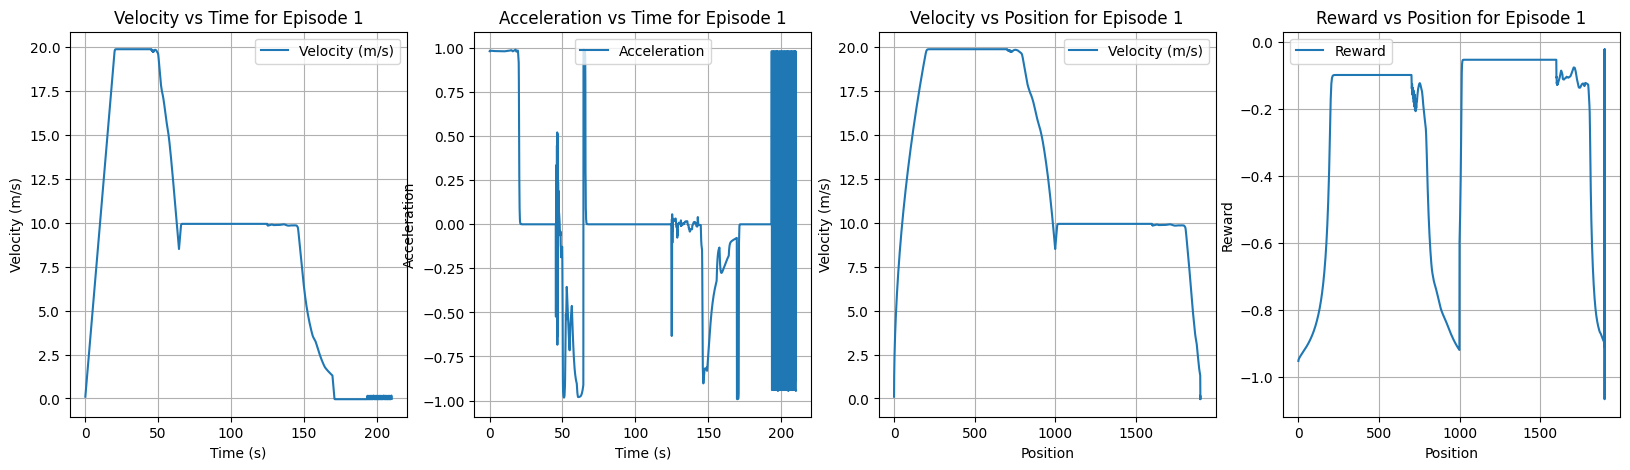

In [18]:
    plt.figure(figsize=(20, 5))

    plt.subplot(1, 4, 1)
    plt.plot(time_data, velocity_data, label='Velocity (m/s)')
    plt.xlabel('Time (s)')
    plt.ylabel('Velocity (m/s)')
    plt.title('Velocity vs Time for Episode {}'.format(episode))
    plt.legend()
    plt.grid(True)

    plt.subplot(1, 4, 2)
    plt.plot(time_data, acceleration_data, label='Acceleration')
    plt.xlabel('Time (s)')
    plt.ylabel('Acceleration')
    plt.title('Acceleration vs Time for Episode {}'.format(episode))
    plt.legend()
    plt.grid(True)

    plt.subplot(1, 4, 3)
    plt.plot(position_data, velocity_data, label='Velocity (m/s)')
    plt.xlabel('Position')
    plt.ylabel('Velocity (m/s)')
    plt.title('Velocity vs Position for Episode {}'.format(episode))
    plt.legend()
    plt.grid(True)

    plt.subplot(1, 4, 4)
    plt.plot(position_data, reward_data, label='Reward')
    plt.xlabel('Position')
    plt.ylabel('Reward')
    plt.title('Reward vs Position for Episode {}'.format(episode))
    plt.legend()
    plt.grid(True)
    plt.show()